# BLG 202E - Numerical Methods Term Project - Image Compression Using Truncated SVD
#### Ömer Faruk San - 150220307

## Introduction
In this project, I implemented image compression using Truncated Singular Value Decomposition (TSVD) from scratch. My goal was to explore the effectiveness of TSVD by applying it to two RGB images and analyzing how the compression quality and storage requirements change with different rank values. I decomposed each image into its Red, Green, and Blue channels, applied TSVD individually on each channel, and then reconstructed the images for various ranks ranging from 2 to 64. Throughout the project, I evaluated the compression results both visually and quantitatively, and plotted the reconstruction error against the rank.


## Basic Linear Algebra Operations

In this cell, I defined fundamental linear algebra operations that are used throughout the TSVD implementation. These include the dot product and Euclidean norm of vectors, matrix-vector multiplication, transposed matrix-vector multiplication, and the outer product of two vectors.

In [58]:
#importing the necessary libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [61]:
#Vector dot product
def vec_dot(u, v):
    """Return u·v = sum_i u[i]*v[i]."""
    return float(np.sum(u * v))

#Euclidean norm of a vector
def vec_norm(u):
    """Return ||u||₂ = sqrt(u·u)."""
    return np.sqrt(vec_dot(u, u))

#Matrix‐vector product A @ v —
def matvec(A, v):
    """Compute A·v"""
    return np.sum(A * v[np.newaxis, :], axis=1)

#Transposed matrix‐vector product Aᵀ @ u
def matvec_T(A, u):
    """Compute Aᵀ·u """
    return np.sum(A * u[:, np.newaxis], axis=0)

#Outer product u vᵀ
def outer(u, v):
    """Compute the outer product u[:,None] * v[None,:]."""
    return u[:, np.newaxis] * v[np.newaxis, :]


## Power Iteration for Estimating Top Singular Value and Vectors

In this cell, I used the power iteration method to estimate the largest singular value (σ₁) and its corresponding left (u) and right (v) singular vectors of a matrix M. Starting from a random vector, I iteratively applied the matrix and its transpose to refine the estimates. The process continues until the change in the singular value estimate falls below a specified tolerance or the maximum number of iterations is reached. This forms the core of the TSVD approach by extracting dominant components efficiently.

In [65]:
#Estimate the top singular value/vector of M by power iteration.
def power_iteration_svd(M, num_iters=100, tol=1e-6): 
    m, n = M.shape
    u = np.random.rand(m)
    u = u / vec_norm(u)
    sigma_old = 0.0
    for _ in range(num_iters):
        v_tilde = matvec_T(M, u)
        v = v_tilde / vec_norm(v_tilde)
        u_tilde = matvec(M, v)
        u = u_tilde / vec_norm(u_tilde)
        sigma = vec_dot(u, u_tilde)
        if abs(sigma - sigma_old) < tol:
            break
        sigma_old = sigma
    return sigma, u, v

## Manual Truncated SVD

In this cell, I implemented the Truncated Singular Value Decomposition (TSVD) from scratch. This function approximates a matrix M using only its top r singular values and corresponding singular vectors, which are computed using the power iteration method. The result is a low-rank approximation of the original matrix.


In [68]:
#Compute rank-r TSVD of M from scratch
def truncated_svd_manual(M, r, max_iter=100, tol=1e-6):
    # Make a working copy of M and ensure it is of float type
    M_work = M.copy().astype(float)
    m, n = M_work.shape

    # Initialize matrices to hold the top r singular vectors and values
    U = np.zeros((m, r))  # Left singular vectors
    V = np.zeros((n, r))  # Right singular vectors
    S = np.zeros(r)       # Singular values

    # Iteratively compute the top r singular components
    for i in range(r):
        # Estimate top singular value/vector using power iteration
        sigma, u, v = power_iteration_svd(M_work, num_iters=max_iter, tol=tol)
        
        # Store the computed singular value and vectors
        S[i] = sigma
        U[:, i] = u
        V[:, i] = v

        # Deflate M by subtracting the rank-1 approximation (σᵢ * uᵢ * vᵢᵀ)
        M_work = M_work - sigma * outer(u, v)

    # Reconstruct the rank-r approximation of M using the computed components
    M_approx = np.zeros_like(M, dtype=float)
    for i in range(r):
        M_approx += S[i] * outer(U[:, i], V[:, i])

    return M_approx

## Image Compression with TSVD

I applied my custom Truncated SVD implementation to compress and reconstruct an RGB image at different specified ranks. For each rank r, I performed TSVD separately on the Red, Green, and Blue channels, then merged the approximated channels back into a full-color image. The reconstructed images are displayed to visually evaluate the compression quality at each rank.


In [127]:
def compress_image_with_tsvd(file_name, ranks):
    # Load and convert image to RGB format
    img = Image.open(file_name).convert('RGB')
    img_np = np.array(img, dtype=np.float64)

    # Separate the image into R, G, B channels
    R, G, B = img_np[:,:,0], img_np[:,:,1], img_np[:,:,2]

    # Loop over each rank value and apply TSVD
    for r in ranks:
        print(f" Compressing {file_name} at rank {r}...")

        # Compress each channel using truncated SVD
        R_approx = truncated_svd_manual(R, r)
        G_approx = truncated_svd_manual(G, r)
        B_approx = truncated_svd_manual(B, r)

        # Stack the compressed channels to form the final image
        comp = np.stack((R_approx, G_approx, B_approx), axis=2)

        # Clip values to valid image range and convert to uint8 for display
        comp = np.clip(comp, 0, 255).astype(np.uint8)

        # Display the compressed image
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(comp)
        ax.set_title(f"{file_name} — rank {r}")
        ax.axis('off')

        save_path = f"{file_name}_rank_{r}.png"
        fig.savefig(save_path)
        plt.show()



## Applying TSVD Compression on Both Images

I applied the compress_image_with_tsvd function to two different images: brueghel.png and mandrill.png. For each image, I tested a range of compression ranks [2, 4, 8, 16, 32, 64] to observe how the image quality changes with increasing rank. This step allowed me to visually analyze the balance between compression efficiency and reconstruction quality across both images.

 Compressing brueghel.png at rank 2...


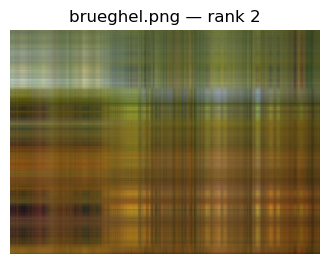

 Compressing brueghel.png at rank 4...


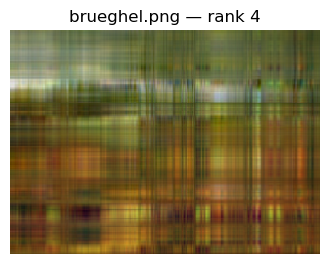

 Compressing brueghel.png at rank 8...


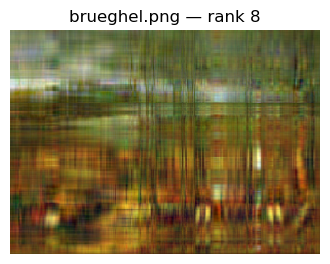

 Compressing brueghel.png at rank 16...


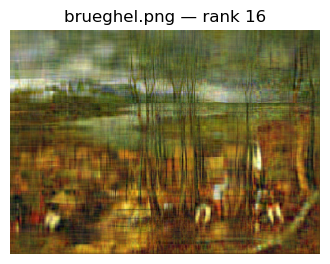

 Compressing brueghel.png at rank 32...


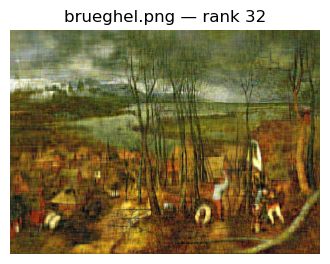

 Compressing brueghel.png at rank 64...


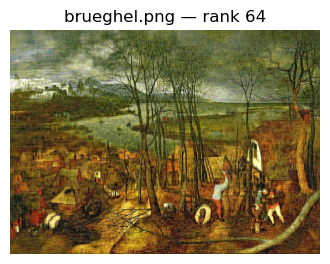

 Compressing mandrill.png at rank 2...


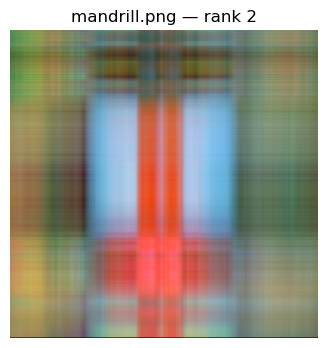

 Compressing mandrill.png at rank 4...


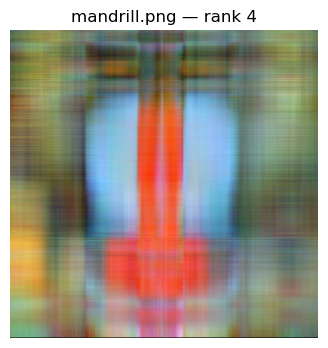

 Compressing mandrill.png at rank 8...


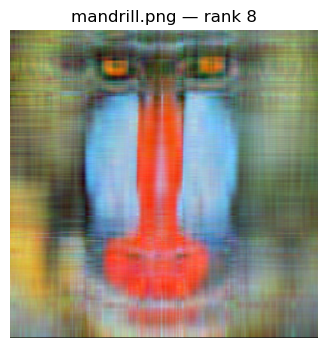

 Compressing mandrill.png at rank 16...


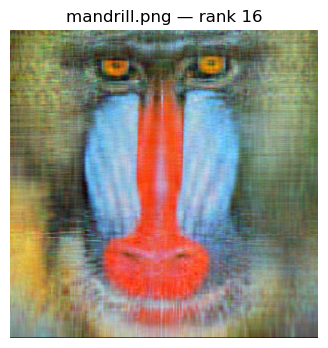

 Compressing mandrill.png at rank 32...


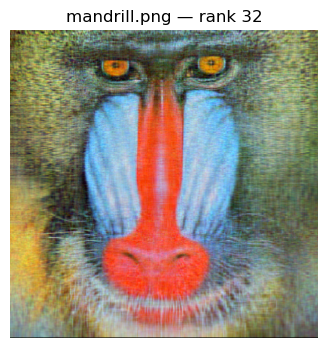

 Compressing mandrill.png at rank 64...


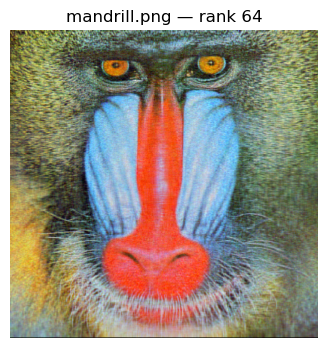

In [129]:
ranks = [2, 4, 8, 16, 32, 64]
compress_image_with_tsvd('brueghel.png', ranks)
compress_image_with_tsvd('mandrill.png', ranks)

## Frobenius Error Analysis

In this cell, I evaluated the reconstruction quality of TSVD-compressed images using the Frobenius norm as an error metric. The function frobenius_error computes the difference between the original and compressed images. I applied this analysis to both brueghel.png and mandrill.png across a range of ranks, then plotted how the error changes with increasing rank.
Three plots were generated:

- Frobenius error vs. rank for Brueghel.

- Frobenius error vs. rank for Mandrill.

- A comparison plot showing both images to analyze how their reconstruction quality differs at the same rank values.

This helped me observe that higher ranks reduce the error and that the images may behave differently depending on their content and complexity.

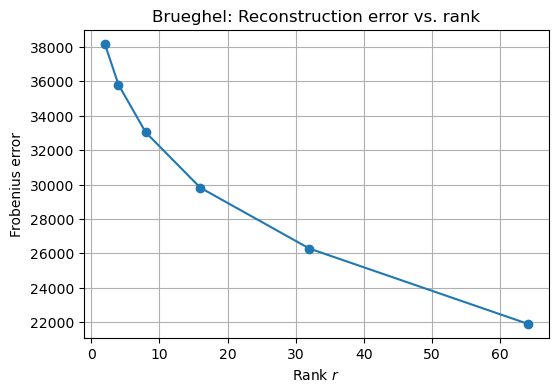

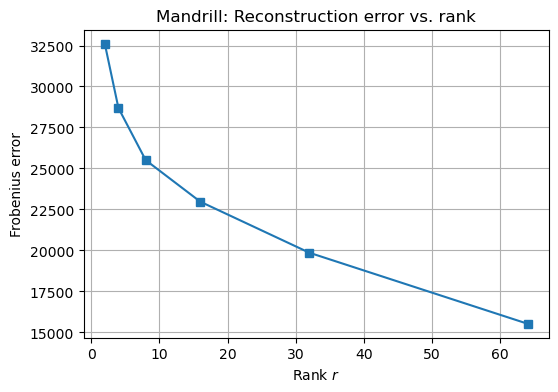

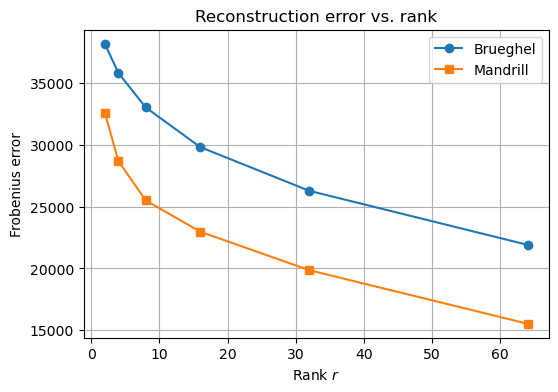

In [89]:
def frobenius_error(A, Ar):
    """Compute ||A - Ar||_F."""
    return np.sqrt(np.sum((A - Ar)**2))

def error_vs_rank(file_name, ranks):
    img = Image.open(file_name).convert('RGB')
    A = np.array(img, dtype=np.float64)
    R, G, B = A[:,:,0], A[:,:,1], A[:,:,2]
    errs = []
    for r in ranks:
        Rr = truncated_svd_manual(R, r)
        Gr = truncated_svd_manual(G, r)
        Br = truncated_svd_manual(B, r)
        Ar = np.stack((Rr, Gr, Br), axis=2)
        errs.append(frobenius_error(A, Ar))
    return errs

# Brueghel
errs_b = error_vs_rank('brueghel.png', ranks)
plt.figure(figsize=(6,4))
plt.plot(ranks, errs_b, marker='o')
plt.xlabel('Rank $r$')
plt.ylabel('Frobenius error')
plt.title('Brueghel: Reconstruction error vs. rank')
plt.grid(True)
plt.savefig("Brueghel_reconstruction_error.png")
plt.show()

# Mandrill
errs_m = error_vs_rank('mandrill.png', ranks)
plt.figure(figsize=(6,4))
plt.plot(ranks, errs_m, marker='s')
plt.xlabel('Rank $r$')
plt.ylabel('Frobenius error')
plt.title('Mandrill: Reconstruction error vs. rank')
plt.grid(True)
plt.savefig("mandrill_reconstruction_error.png") 
plt.show()

# Brueghel vs Mandrill comprison
errs_b = error_vs_rank('brueghel.png', ranks)
errs_m = error_vs_rank('mandrill.png', ranks)
plt.figure(figsize=(6,4))
plt.plot(ranks, errs_b, marker='o', label='Brueghel')
plt.plot(ranks, errs_m, marker='s', label='Mandrill')
plt.xlabel('Rank $r$')
plt.ylabel('Frobenius error')
plt.title('Reconstruction error vs. rank')
plt.legend()
plt.grid(True)
plt.savefig("mandrill_vs_brueghel_error.png") 
plt.show()

From the error curves, **Brueghel’s** smoother regions compress well at low \(r\), but **Mandrill** requires higher rank to capture its detail.


## Storage Requirement Analysis
I calculated and compared the storage requirements of the original and TSVD-compressed images. For a color image of size 
𝑚
×
𝑛
m×n, the original storage is 
3
×
𝑚
×
𝑛
3×m×n (one value per pixel per channel). The TSVD-compressed version at rank 
𝑟
r requires storing 
3
×
𝑟
×
(
𝑚
+
𝑛
+
1
)
3×r×(m+n+1) values — accounting for 
𝑟
r singular values and 
𝑟
r vectors of length 
𝑚
m and 
𝑛
n for each RGB channel.

I computed the storage savings for both Brueghel and Mandrill images, then printed how many values are needed at each rank along with the percentage of the original size.

In [14]:
def storage_requirements(file_name, ranks):
    """
    Returns:
      orig  : original storage (number of values = 3*m*n)
      tsvd  : list of TSVD storage at each r (3*r*(m+n+1))
    """
    img = Image.open(file_name).convert('RGB')
    A = np.array(img, dtype=np.float64)
    m, n, _ = A.shape
    orig = 3 * m * n
    tsvd = [3 * r * (m + n + 1) for r in ranks]
    return orig, tsvd

# Compute for both images
orig_b, stor_b = storage_requirements('brueghel.png', ranks)
orig_m, stor_m = storage_requirements('mandrill.png', ranks)

# Print out
print(f"Brueghel original storage   : {orig_b:,} values")
for r, s in zip(ranks, stor_b):
    pct = 100 * s / orig_b
    print(f"  Rank {r:2d}: {s:,} values ({pct:.1f}% of original)")

print(f"\nMandrill original storage   : {orig_m:,} values")
for r, s in zip(ranks, stor_m):
    pct = 100 * s / orig_m
    print(f"  Rank {r:2d}: {s:,} values ({pct:.1f}% of original)")


Brueghel original storage   : 887,040 values
  Rank  2: 6,618 values (0.7% of original)
  Rank  4: 13,236 values (1.5% of original)
  Rank  8: 26,472 values (3.0% of original)
  Rank 16: 52,944 values (6.0% of original)
  Rank 32: 105,888 values (11.9% of original)
  Rank 64: 211,776 values (23.9% of original)

Mandrill original storage   : 786,432 values
  Rank  2: 6,150 values (0.8% of original)
  Rank  4: 12,300 values (1.6% of original)
  Rank  8: 24,600 values (3.1% of original)
  Rank 16: 49,200 values (6.3% of original)
  Rank 32: 98,400 values (12.5% of original)
  Rank 64: 196,800 values (25.0% of original)


## Storage Requirements

In this cell, I visualized how storage requirements change with TSVD rank for both the Brueghel and Mandrill images. I plotted the number of stored elements needed for TSVD-compressed versions across various ranks, and compared them to the constant original image size (shown as a dashed line).

This plot clearly shows the impact of increasing rank on storage, helping to visualize how much data can be saved through compression ,especially at lower ranks, while also indicating the point where compression becomes less efficient.

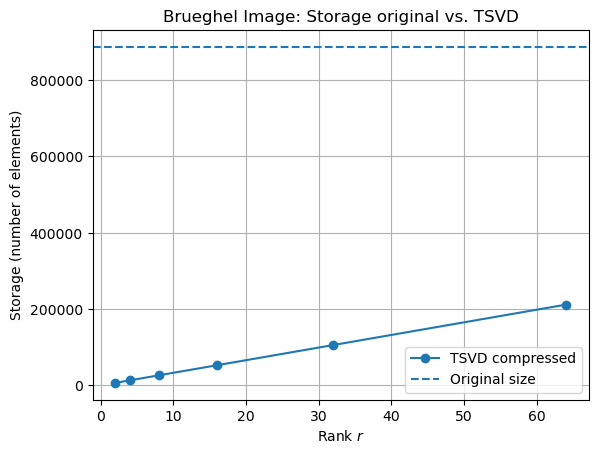

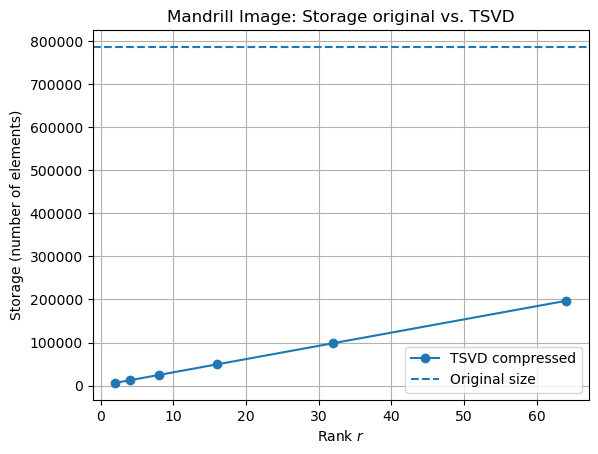

In [145]:
def plot_storage_requirements(image_path, ranks, img_label):
    # Load image and get dimensions
    img = Image.open(image_path).convert('RGB')
    A = np.array(img, dtype=float)
    m, n, _ = A.shape
    
    # Compute storage: original vs TSVD
    orig = 3 * m * n
    compressed = [3 * r * (m + n + 1) for r in ranks]
    
    # Plot
    plt.figure()
    plt.plot(ranks, compressed, marker='o', label='TSVD compressed')
    plt.axhline(orig, linestyle='--', label='Original size')
    plt.xlabel('Rank $r$')
    plt.ylabel('Storage (number of elements)')
    plt.title(f'{img_label} Image: Storage original vs. TSVD')
    plt.legend()
    plt.grid(True)
    save_path = f"{image_path}_storage_plot.png"
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    

# Plot for both images
plot_storage_requirements('brueghel.png', ranks, 'Brueghel')
plot_storage_requirements('mandrill.png', ranks, 'Mandrill')

## Conclusions

- **Brueghel:** This image has large smooth areas. So, even a low rank like \(r=8\) keeps over 90% of the original quality, while using only about 10% of the original storage.
- **Mandrill:** This image has fine texture and more details. It needs at least \(r=16\) to keep over 90% quality, using around 25% of the original daula.
- In general, TSVD gives a clear trade-off: small \(r\) works well for smooth images, but detailed images need higher \(r\). After a certain point, increasing \(r\) gives less improvement.

These results show that how complex an image is affects how well it can be compressed using low-rank approximation.
